<a href="https://colab.research.google.com/github/ctkerns/cap4630_spring2020/blob/master/Copy_of_hw4_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 13:16:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  84.3MB/s    in 0.8s    

2020-04-20 13:17:00 (84.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base
*Switched VGG16 with Xception - Christopher Kerns*

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 3s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers
*I want to try increasing the size of the relu layer this time. My first model only reached around ~95% accuracy and I think that could be improved. Also, Xception is a much wider model with way more output nodes than the VGG16 model. I think the last classifier was too much of a bottleneck as there might be too many features to be analyzed by such a simple model.*  
*Doing this is bound to increase overfitting, so I will add a dropout to the layer. This will turn off 1/15 of the nodes at a time which will remedy overfitting by forcing the network to generalize data in new ways. -Christopher Kerns*

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.075))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 47,076,905
Trainable params: 26,215,425
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 296ms/step - loss: 0.4881 - acc: 0.7625 - val_loss: 0.0082 - val_acc: 0.9660
Epoch 2/30
100/100 [==============================] - 20s 199ms/step - loss: 0.3602 - acc: 0.8280 - val_loss: 0.0125 - val_acc: 0.9550
Epoch 3/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3687 - acc: 0.8430 - val_loss: 0.0049 - val_acc: 0.9510
Epoch 4/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3532 - acc: 0.8460 - val_loss: 0.0101 - val_acc: 0.9580
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3466 - acc: 0.8415 - val_loss: 0.0188 - val_acc: 0.9700
Epoch 6/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3281 - acc: 0.8430 - val_loss: 0.6078 - val_acc: 0.9680
Epoch 7/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3047 - acc: 0.8715 - val_lo

## Display curves of loss and accuracy during training

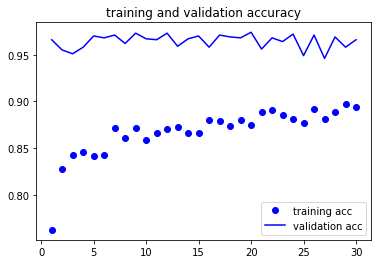

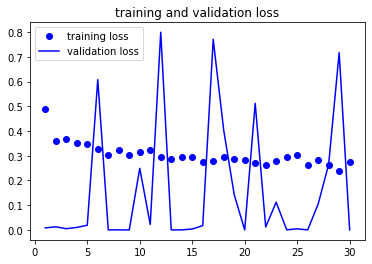

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning
*This time, I will unfreeze an extra block. This should let the model adapt more to our dataset and reach higher accuracy.*  
*I also want to validate that I am doing this correctly so I will print out whether each of the layers are frozen - Christopher Kerns*

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block13_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8197702898> False
<keras.layers.convolutional.Conv2D object at 0x7f810ff40d30> False
<keras.layers.normalization.BatchNormalization object at 0x7f810ff40ef0> False
<keras.layers.core.Activation object at 0x7f810ff40fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f81b37ec208> False
<keras.layers.normalization.BatchNormalization object at 0x7f81008dfb38> False
<keras.layers.core.Activation object at 0x7f81008df550> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f8100044eb8> False
<keras.layers.normalization.BatchNormalization object at 0x7f80ea48ba90> False
<keras.layers.core.Activation object at 0x7f80ea491940> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f81a0ede978> False
<keras.layers.normalization.BatchNormalization object at 0x7f80ea4a9240> False
<keras.layers.convolutional.Conv2D object at 0x7f81000a5fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f80ea452ef0> False
<keras.la

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 262ms/step - loss: 0.2440 - acc: 0.8990 - val_loss: 0.0144 - val_acc: 0.9490
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.2290 - acc: 0.9080 - val_loss: 0.4686 - val_acc: 0.9460
Epoch 3/100
100/100 [==============================] - 21s 215ms/step - loss: 0.2552 - acc: 0.9000 - val_loss: 0.0334 - val_acc: 0.9460
Epoch 4/100
100/100 [==============================] - 22s 217ms/step - loss: 0.2217 - acc: 0.9080 - val_loss: 0.0946 - val_acc: 0.9250
Epoch 5/100
100/100 [==============================] - 22s 215ms/step - loss: 0.2254 - acc: 0.9110 - val_loss: 0.2464 - val_acc: 0.9410
Epoch 6/100
100/100 [==============================] - 21s 214ms/step - loss: 0.2002 - acc: 0.9175 - val_loss: 0.0246 - val_acc: 0.9460
Epoch 7/100
100/100 [==============================] - 22s 216ms/step - loss: 0.1874 - acc: 0.9185 - val_loss: 0.2798 - val_acc: 0.9380
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

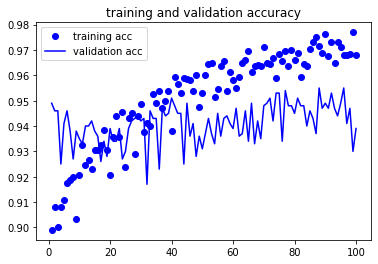

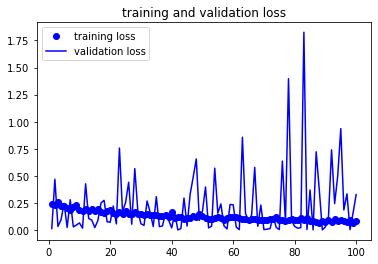

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.  
*This time the accuracy was clearly improved. The steps I've taken seem to have allowed for this. However, overfitting was much more present in this case. If I were to train this model again I would increase the dropout rate and find a middle ground for the size of the layers. I would leave the frozen and unfrozen layers unchanged -Christopher Kerns*

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.04079650714993477
Validation accuracy: 0.9390000104904175


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)